# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
Y = pd.read_csv('exons_counts.csv',index_col=[0])
X = pd.read_csv('time_points.csv',index_col=[0])
#X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
X

,time
E11_1_F,95.0
E12_1_F,105.0
E13A_1_F,115.0
E13B_1_F,125.0
E14A_1_F,145.0
E14B_1_F,160.0
E14C_1_F,175.0
E14D_1_F,190.0
E14E_1_F,205.0
ECF_1_F,220.0


In [3]:
((10*(len(X)))/100)

3.0

Fit some fission gene normalized data using GPcounts -- Two samples test

In [4]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [5]:
genes_name = [
 'FBgn0003638',
 'FBgn0004237',
 'FBgn0010226',
 'FBgn0010504',
 'FBgn0011888',
 'FBgn0011944',
 'FBgn0011994',
 'FBgn0013679',
 'FBgn0013681',
 'FBgn0013684',
 'FBgn0015791',
 'FBgn0022710']
 

In [6]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio,variances_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 12/12 [00:36<00:00,  3.04s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0003638,-116.481716,-116.343844,-0.137872
FBgn0004237,-152.922085,-151.680398,-1.241687
FBgn0010226,-160.570247,-156.980248,-3.590000
FBgn0010504,-95.817384,-94.600994,-1.216390
FBgn0011888,-87.025257,-89.167871,2.142614
FBgn0011944,-25.073856,-26.077080,1.003224
FBgn0011994,-22.001217,-21.124805,-0.876412
FBgn0013679,-163.364111,-163.414699,0.050588
FBgn0013681,-94.935706,-97.937969,3.002263
FBgn0013684,-168.366113,-166.276327,-2.089786


In [7]:
variances_ratio

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0003638,26.455797,37.488328,-11.032531
FBgn0004237,155.231754,37.484965,117.746789
FBgn0010226,203.893457,37.489449,166.404008
FBgn0010504,110.276892,37.485586,72.791305
FBgn0011888,2.537458,37.470523,-34.933065
FBgn0011944,2.224177,0.821834,1.402343
FBgn0011994,32.751156,1.767384,30.983772
FBgn0013679,22.428185,37.481495,-15.053310
FBgn0013681,8.681699,4.615079,4.066620
FBgn0013684,338.346220,37.488427,300.857793


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


FBgn0003638


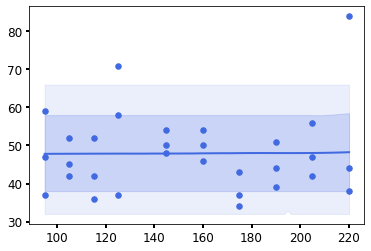

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,26.45579741523395
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6870.500878580573
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.025001287295613017
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[7.51236625e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.01298733e-02, 0.00000000e+00, 0.00000000e+00..."


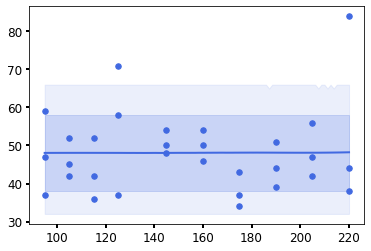

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.488327972401834
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.025001287295613017
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[6.32134960e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.38596980e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0004237


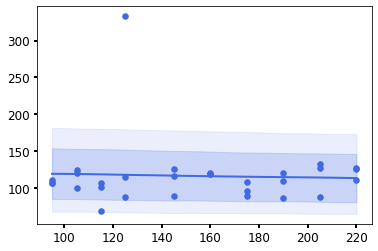

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,155.2317538399205
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4833.057746164212
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.07795216252472409
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[3.83110316e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.94472344e-03, 0.00000000e+00, 0.00000000e+00..."


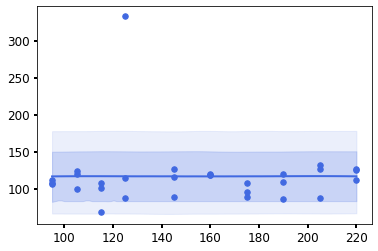

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.48496457696783
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.07795216252472409
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[7.76633983e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[8.77339724e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0010226


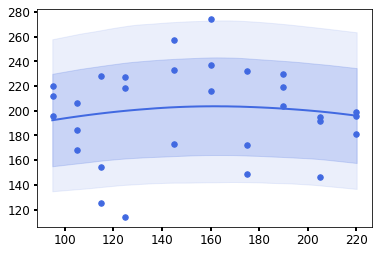

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,203.89345696545098
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,681.0898933180719
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.033375968766193496
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[3.67955165e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[4.93439367e-03, 0.00000000e+00, 0.00000000e+00..."


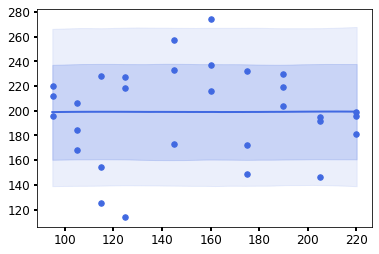

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.489448803317416
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.033375968766193496
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[8.64206983e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-5.84388329e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0010504


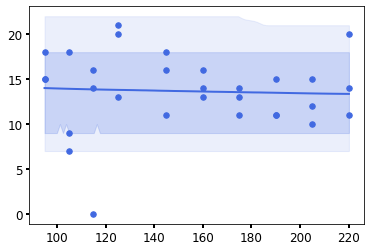

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,110.2768915968003
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3845.9610200449424
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.03628531577367683
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[2.50318040e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[9.17089227e-03, 0.00000000e+00, 0.00000000e+00..."


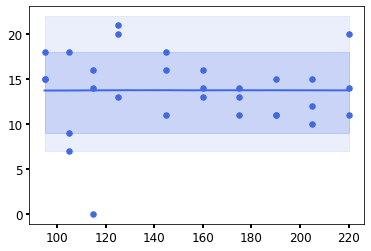

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.485586446794095
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.03628531577367683
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[4.27359426e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-9.86159304e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0011888


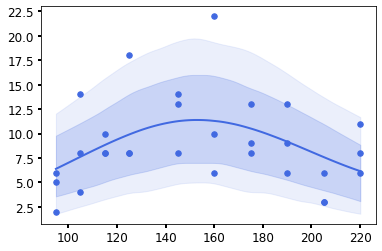

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.537457996160691
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,99.03714178085407
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.07477757045177134
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.15418246e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.13124934e-01, 0.00000000e+00, 0.00000000e+00..."


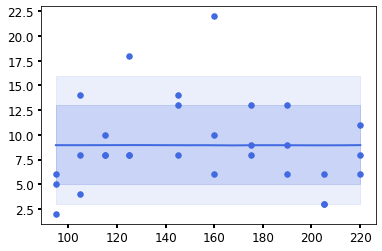

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.47052278485156
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.07477757045177134
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[3.56956689e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.29140553e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0011944


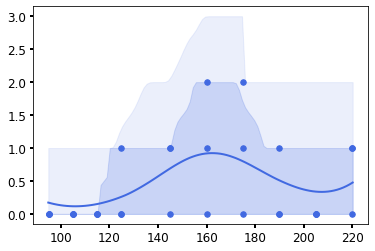

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.224177195948095
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,33.08289926473754
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,5.4928085819643635e-05
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-1.54012299e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.54447881e-01, 0.00000000e+00, 0.00000000e+00..."


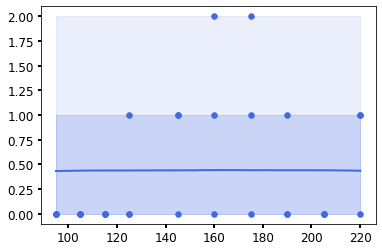

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.8218341604858651
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,5.4928085819643635e-05
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-9.56426262e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.92003397e-01, 0.00000000e+00, 0.00000000e+00..."


FBgn0011994


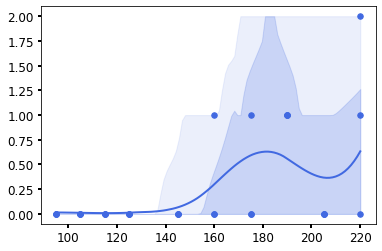

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,32.751155531630445
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,26.375530334054258
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,5.208056208503047e-12
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-1.13549587e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[4.21689301e-01, 0.00000000e+00, 0.00000000e+00..."


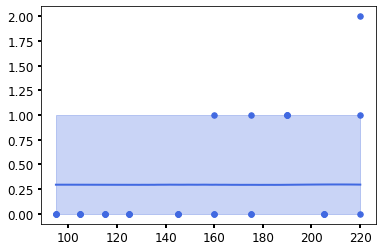

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.7673840025091192
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,5.208056208503047e-12
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-9.69093950e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.46728465e-01, 0.00000000e+00, 0.00000000e+00..."


FBgn0013679


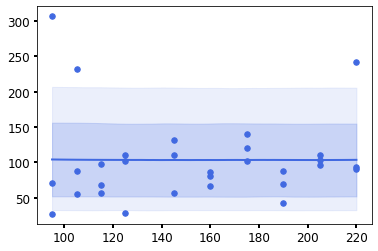

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,22.428185405545403
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,13005.752890876098
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.2680971044034718
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.78167122e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.07893596e-02, 0.00000000e+00, 0.00000000e+00..."


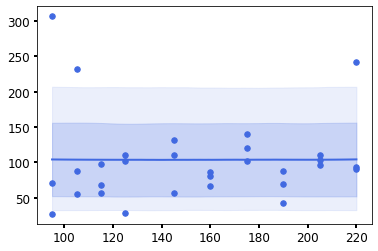

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.481494922551434
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.2680971044034718
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[7.56809310e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.57127560e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0013681


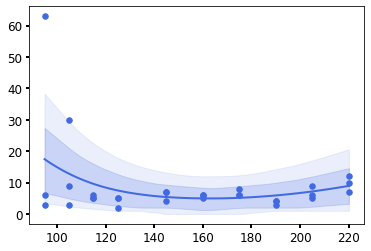

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.681698501019387
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,91.03205781132799
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.3643488364425809
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.58251994e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[8.38384300e-02, 0.00000000e+00, 0.00000000e+00..."


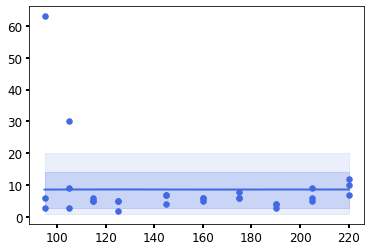

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.615078520801929
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.3643488364425809
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.98258467e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.88171119e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0013684


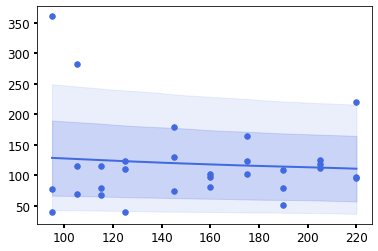

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,338.34621952341814
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2296.778482642492
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.2421680193019048
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[2.63028184e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[8.14959309e-03, 0.00000000e+00, 0.00000000e+00..."


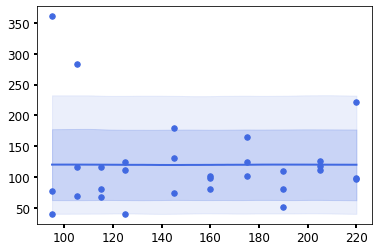

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.48842686374156
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.2421680193019048
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[7.80321946e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.49204391e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0015791


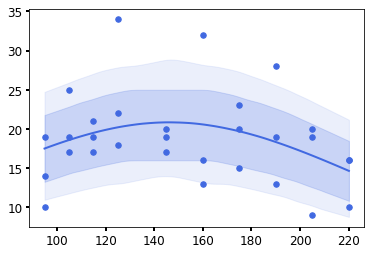

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.283581586943305
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,188.02620513599953
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.3644434983597453e-07
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.38054559e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[4.27255520e-02, 0.00000000e+00, 0.00000000e+00..."


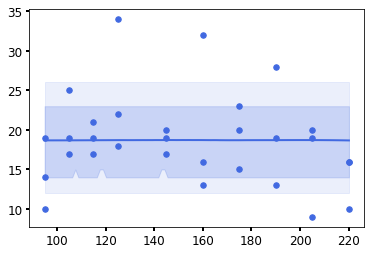

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.493317390333075
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.3644434983597453e-07
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[4.77808358e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.90151939e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0022710


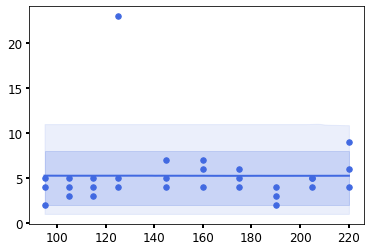

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.7263773794967374
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,108105.34338794276
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.13129113555137756
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.97794126e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.27775026e-02, 0.00000000e+00, 0.00000000e+00..."


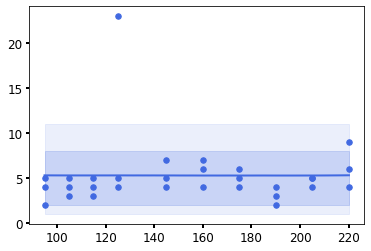

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,37.485617668141494
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.13129113555137756
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[2.70079778e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.69514732e-02, 0.00000000e+00, 0.00000000e+00..."


In [8]:
indexes = genes_name # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [9]:
likelihood = 'Gaussian'
log_likelihood_ratio,var_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0003638,1.229976,1.230142,-0.000166
FBgn0004237,-6.213939,-6.213929,-0.000010
FBgn0010226,0.545547,0.545552,-0.000005
FBgn0010504,-27.521270,-27.521256,-0.000015
FBgn0011888,-21.237937,-22.401008,1.163071
FBgn0011944,-13.544147,-15.100712,1.556565
FBgn0011994,-7.742081,-10.422715,2.680634
FBgn0013679,-27.276798,-27.276792,-0.000005
FBgn0013681,-29.692341,-29.691898,-0.000444
FBgn0013684,-24.708073,-24.708022,-0.000052


100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


FBgn0003638


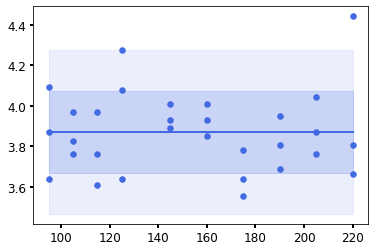

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.9762
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,240232
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0395107


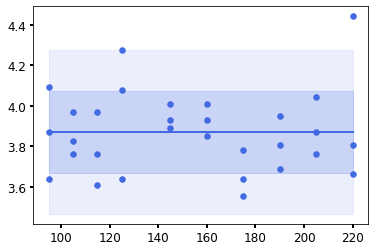

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.9834
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.03951


FBgn0004237


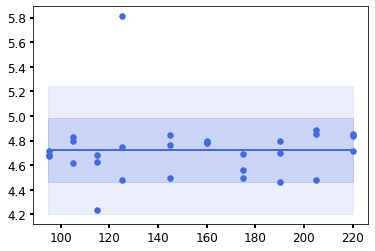

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,22.3094
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,956011
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0651176


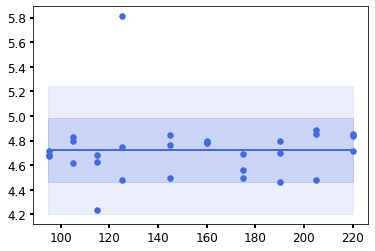

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,22.3104
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0651188


FBgn0010226


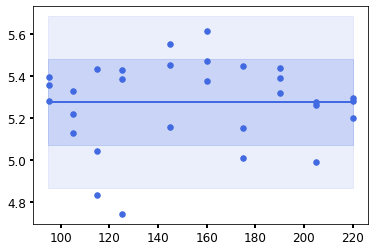

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,27.8642
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.83431e+06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0405441


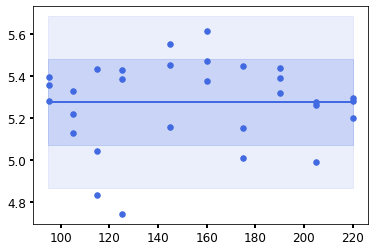

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,27.8522
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0405441


FBgn0010504


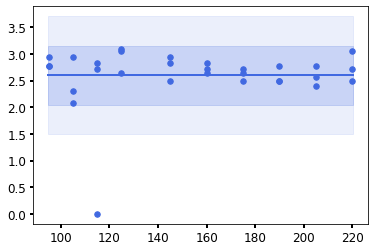

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.77074
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,170678
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.294934


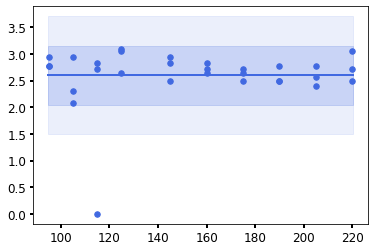

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.77145
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.294936


FBgn0011888


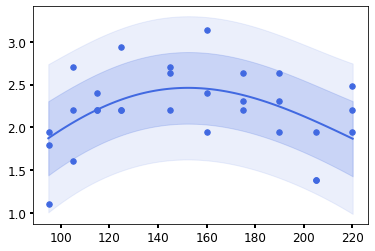

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.61818
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,99.3714
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.162209


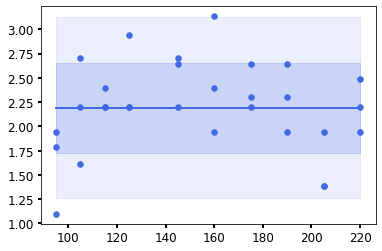

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.81525
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.209639


FBgn0011944


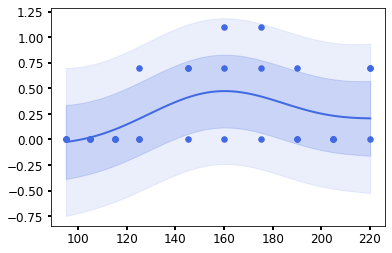

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0849029
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,33.2988
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.114979


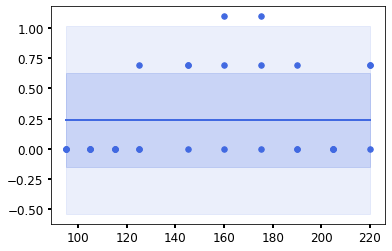

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0617098
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.146875


FBgn0011994


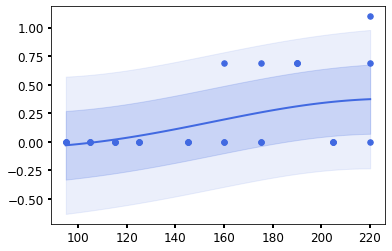

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0756202
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,78.7559
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0820615


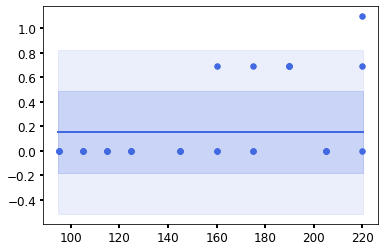

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0270708
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.109251


FBgn0013679


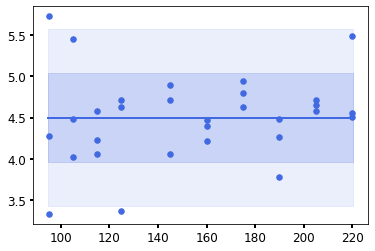

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,20.2631
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,280570
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.279255


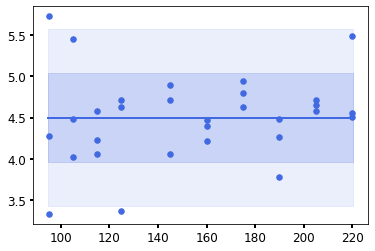

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,20.2652
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.279256


FBgn0013681


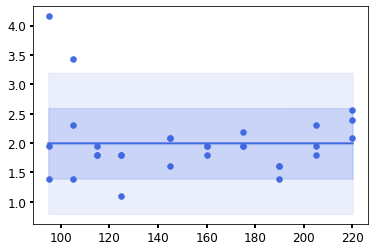

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.9936
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,23799.2
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.348844


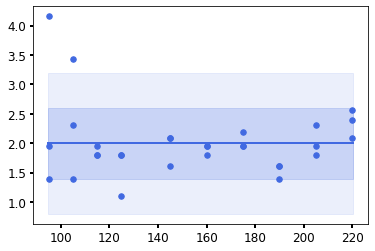

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.9956
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.348831


FBgn0013684


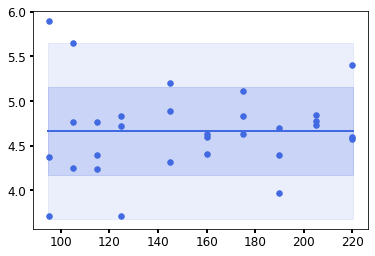

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.7344
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,198974
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.233357


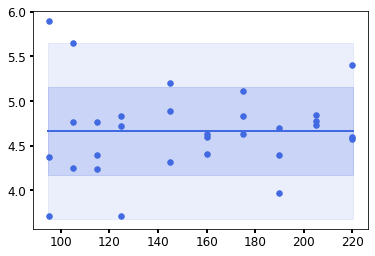

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.737
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.233355


FBgn0015791


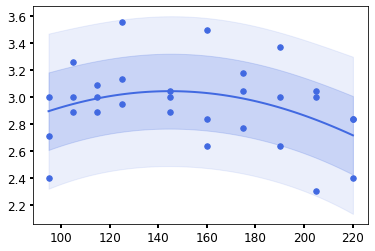

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.30601
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,198.385
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.072941


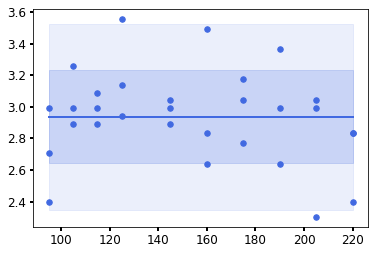

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,8.63345
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0841317


FBgn0022710


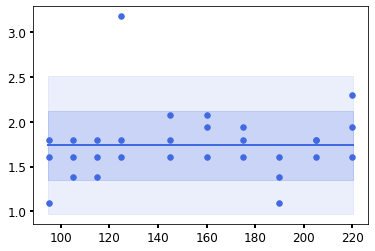

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.02925
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,59841.4
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.142483


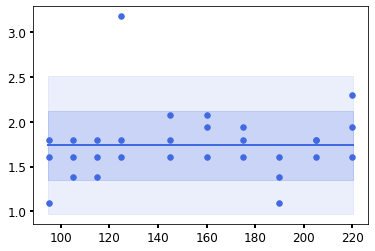

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.03002
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.142482


In [10]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [ ]:
genes_name = [
 'FBgn0000083',
 'FBgn0000108',
 'FBgn0000109',
 'FBgn0000115',
 'FBgn0000221',
 'FBgn0000289',
 'FBgn0000318',
 'FBgn0000464',
 'FBgn0000618',
 'FBgn0001099',
 'FBgn0001202',
 'FBgn0001276',
 'FBgn0001977',
 'FBgn0001995',
 'FBgn0003189']
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [ ]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [ ]:
likelihood = 'Poisson' 
#genes_name = ['FBgn0004185','FBgn0001977']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Poisson'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')